In [160]:
%matplotlib inline

In [161]:
import rpy2.robjects as robjects
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def load_rda(name):
    robjects.r['load']('data/' + name + '.rda')
    matrix = robjects.r[name]
    return np.array(matrix)

plt.rcParams['figure.figsize'] = (13,6)

# Time Series Decomposition - Part 1 Moving Average
Based on https://www.otexts.org/fpp/6/1

## Definitions

### Trend
A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend “changing direction” when it might go from an increasing trend to a decreasing trend.
### Seasonal
A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week). Seasonality is always of a fixed and known period.
### Cyclic
A cyclic pattern exists when data exhibit rises and falls that are not of fixed period. The duration of these fluctuations is usually of at least 2 years.

## Seasonal vs Cyclic
Many people confuse cyclic behaviour with seasonal behaviour, but they are really quite different. If the fluctuations are not of fixed period then they are cyclic; if the period is unchanging and associated with some aspect of the calendar, then the pattern is seasonal. In general, the average length of cycles is longer than the length of a seasonal pattern, and the magnitude of cycles tends to be more variable than the magnitude of seasonal patterns.

## Examples

#### Monthly sales of new one-family houses sold in the USA since 1973.
The monthly housing sales show **strong seasonality** within each year, as well as some **strong cyclic behaviour** with period about 6–10 years. There is no apparent trend in the data over this period.

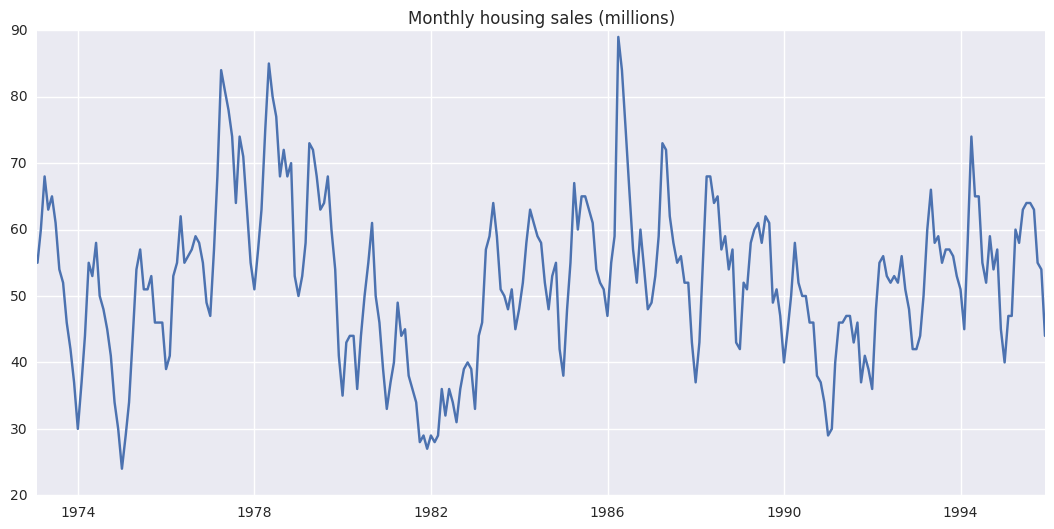

In [3]:
data = load_rda('hsales')
rng = pd.date_range('1/1/1973', periods=data.shape[0], freq='M')
hsales = pd.Series(data, index=rng)
plt.plot(hsales)
_ = plt.title("Monthly housing sales (millions)")

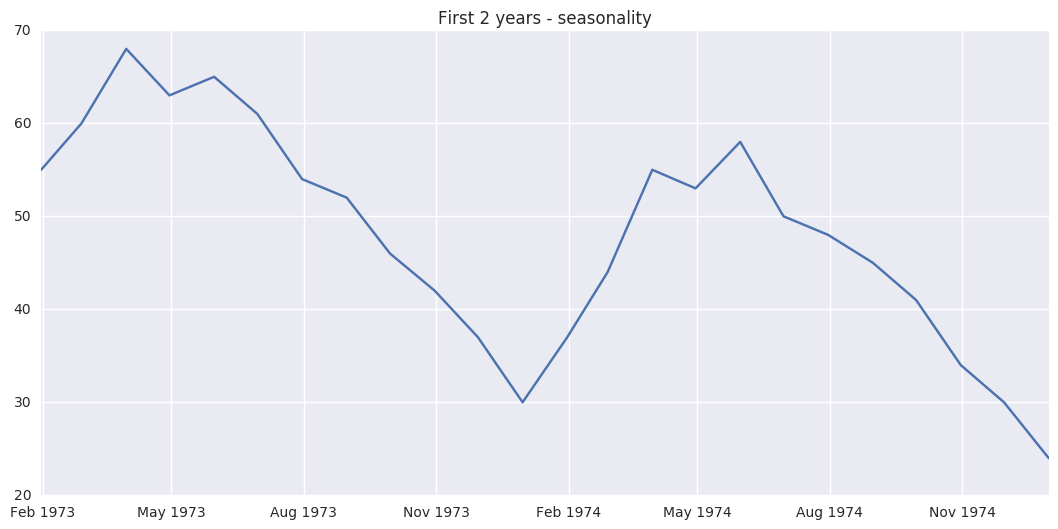

In [7]:
plt.plot(hsales[:24])
plt.title("First 2 years - seasonality")

#### US treasury bill contracts on the Chicago market for 100 consecutive trading days in 1981. 
The US treasury bill contracts show results from the Chicago market for 100 consecutive trading days in 1981. Here there is **no seasonality**, but an obvious **downward trend**. Possibly, if we had a much longer series, we would see that this downward trend is actually part of a long cycle, but when viewed over only 100 days it appears to be a trend.

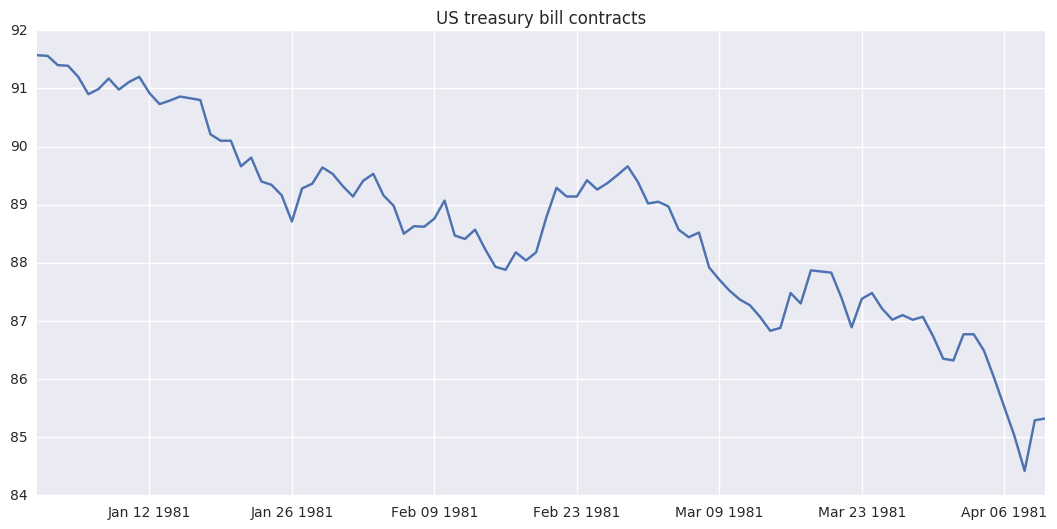

In [8]:
data = load_rda('ustreas')
rng = pd.date_range('1/1/1981', periods=data.shape[0], freq='D')
ustres = pd.Series(data, index=rng)
plt.plot(ustres)
_ = plt.title('US treasury bill contracts')

#### Australian monthly electricity production: Jan 1956 – Aug 1995.
The Australian monthly electricity production shows a **strong increasing trend**, with **strong seasonality**. There is no evidence of any cyclic behaviour here.

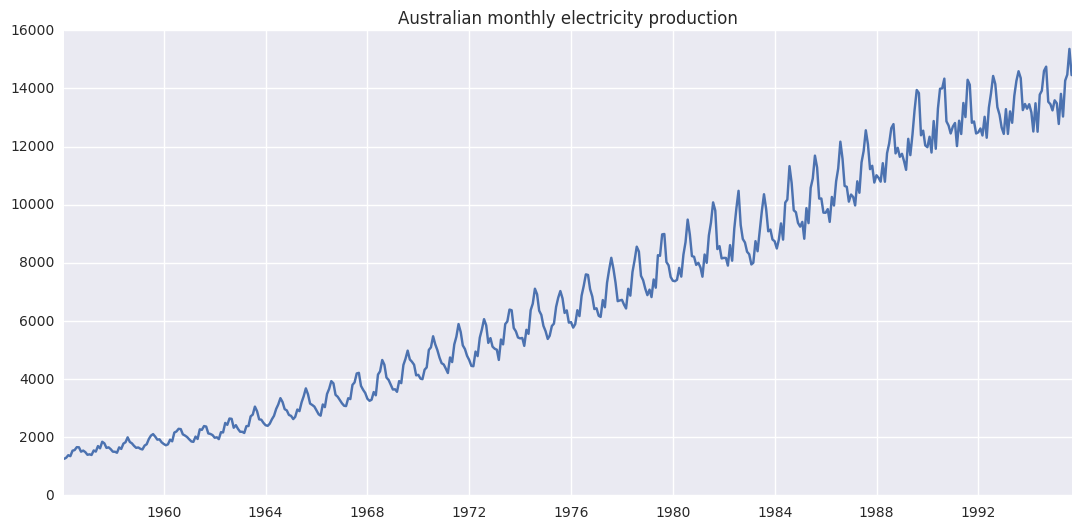

In [10]:
data = load_rda('elec')
rng = pd.date_range('1/1/1956', periods=data.shape[0], freq='M')
elec = pd.Series(data, index=rng)
plt.plot(elec)
_ = plt.title("Australian monthly electricity production")

#### Dow-Jones index on 251 trading days ending 26 Aug 1994.
The daily change in the Dow Jones index has no trend, seasonality or cyclic behaviour. There are random fluctuations which do not appear to be very predictable, and no strong patterns that would help with developing a forecasting model.

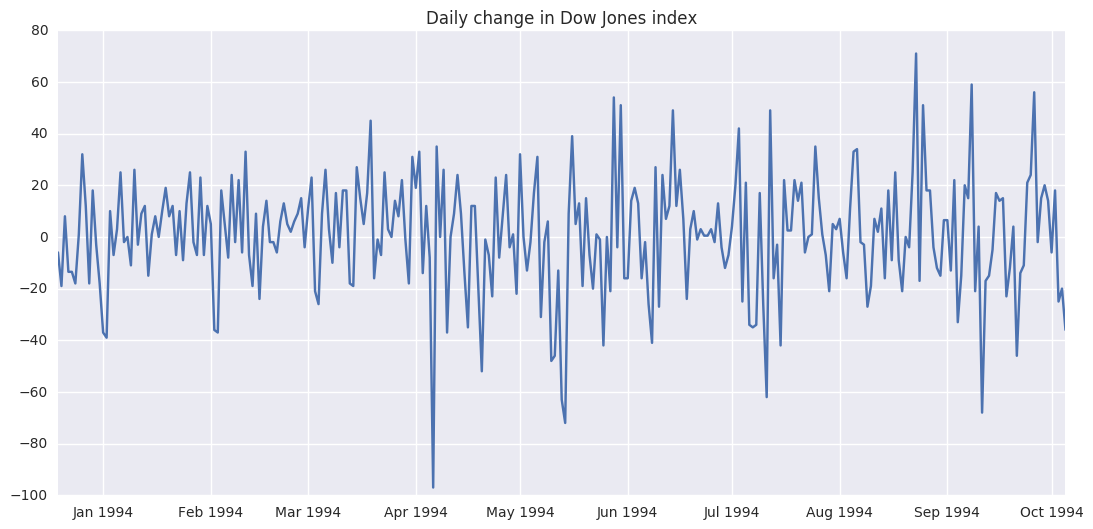

In [13]:
data = load_rda('dj')
rng = pd.date_range('18/12/1993', periods=data.shape[0], freq='D')
dj = pd.Series(data, index=rng)
plt.plot(dj - dj.shift())
_ = plt.title("Daily change in Dow Jones index")

## Time series decomposition
We shall think of the time series $y_t$ as comprising three components: a seasonal component, a trend-cycle component (containing both trend and cycle), and a remainder component (containing anything else in the time series). For example, if we assume an additive model, then we can write

$$ y_t = S_t + T_t + E_t $$

where $y_t$ is the data at period $t$, $S_t$ is the seasonal component at period $t$, $T_t$ is the trend-cycle component at period $t$ and $E_t$ is the remainder (or irregular or error) component at period $t$. Alternatively, a multiplicative model would be written as

$$ y_t = S_t \times T_t \times E_t $$

The additive model is most appropriate if the magnitude of the seasonal fluctuations or the variation around the trend-cycle does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative model is more appropriate. With economic time series, multiplicative models are common.

An alternative to using a multiplicative model, is to first transform the data until the variation in the series appears to be stable over time, and then use an additive model. When a log transformation has been used, this is equivalent to using a multiplicative decomposition because

$$ y_t =  S_t \times T_t \times E_t \hspace{10pt} \text{is equivalent to} \hspace{10pt} \log y_t = \log S_t + \log T_t + \log E_t $$

## Moving Average
The classical method of time series decomposition originated in the 1920s and was widely used until the 1950s. It still forms the basis of later time series methods, and so it is important to understand how it works. The first step in a classical decomposition is to use a moving average method to estimate the trend-cycle.
<br><br>
A moving average of order mm can be written as

$$ \hat{T}_t = \frac{1}{m} \sum_{i = -k}^{k} y_{t+i}$$

where $m=2k+1$. That is, the estimate of the trend-cycle at time $t$ is obtained by averaging values of the time series within $k$ periods of $t$. Observations that are nearby in time are also likely to be close in value, and the average eliminates some of the randomness in the data, leaving a smooth trend-cycle component. We call this an *m*-MA meaning a moving average of order $m$.

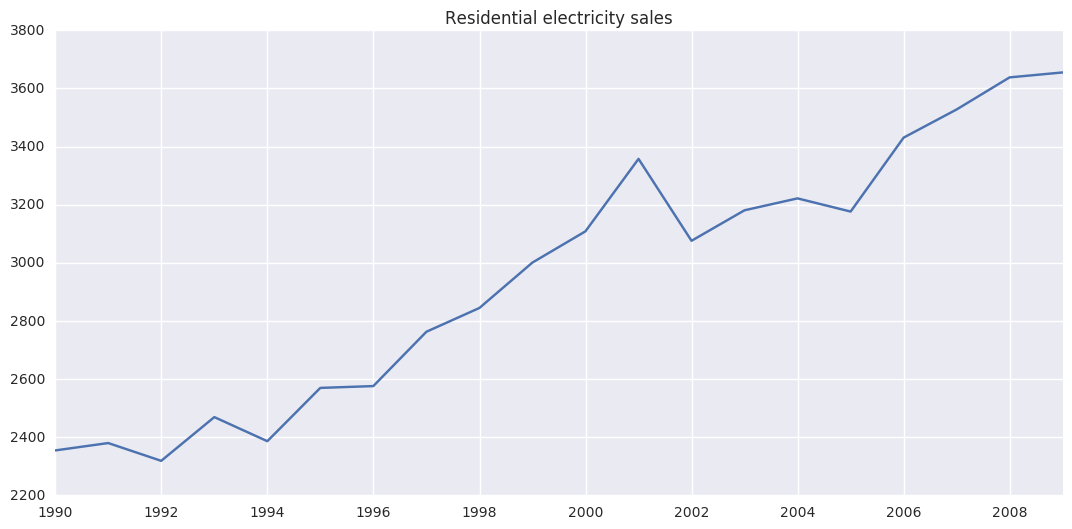

In [69]:
data = load_rda('elecsales')
rng = pd.date_range('1989', periods=data.shape[0], freq='A')
elecsales = pd.Series(data, index=rng)
plt.plot(elecsales)
_ = plt.title("Residential electricity sales")

### 5-MA

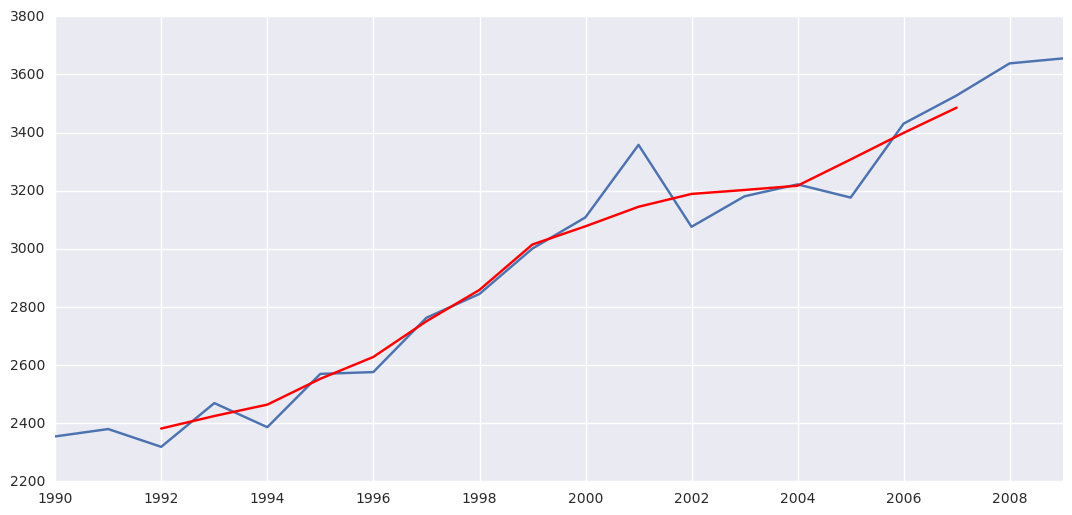

In [88]:
plt.plot(elecsales)
_ = plt.plot(elecsales.rolling(window=5, center=True).mean(), c='red')

The order of the moving average determines the smoothness of the trend-cycle estimate. In general, a larger order means a smoother curve. The following graph shows the effect of changing the order of the moving average for the residential electricity sales data.

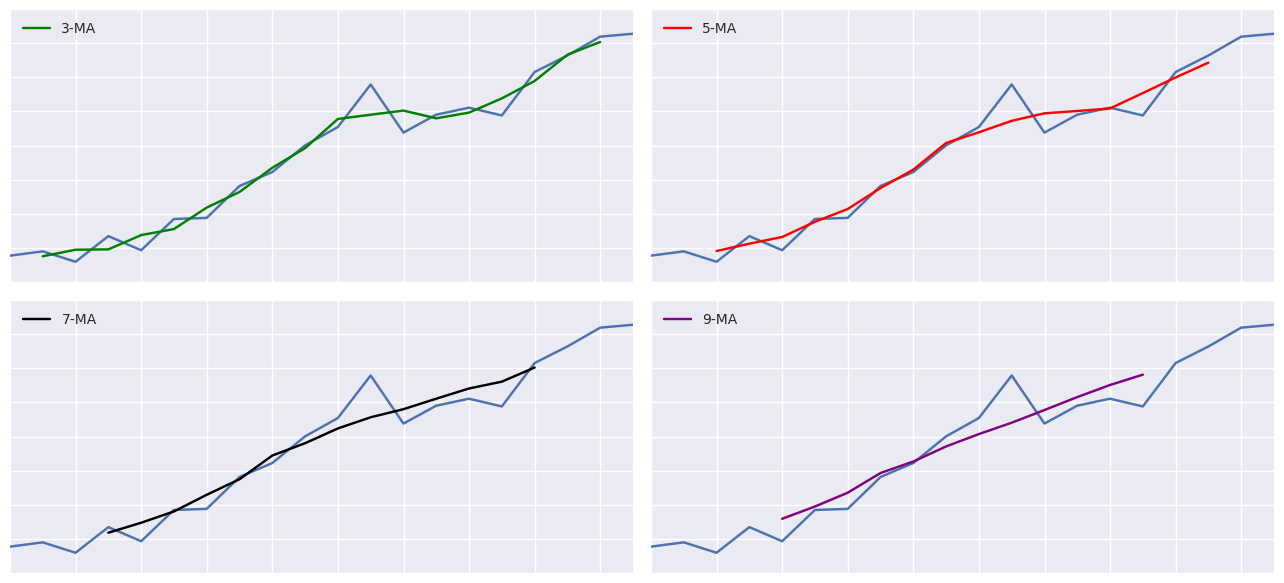

In [48]:
f = plt.figure()
for i, (o, c) in enumerate(zip([3,5,7,9], ['g', 'r', 'k', 'purple'])):
    ax = f.add_subplot(2,2, i+1)
    ax.plot(elecsales)
    ax.plot(elecsales.rolling(window=o, center=True).mean(), c=c, label='{}-MA'.format(o))
    ax.legend(loc='best')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.tight_layout()

### Moving averages of moving averages

It is possible to apply a moving average to a moving average. One reason for doing this is to make an even-order moving average symmetric. For example, we might take a moving average of order 4, and then apply another moving average of order 2 to the results.

In [121]:
import datetime as dt
data = load_rda('ausbeer')
rng = pd.date_range('1/1956', periods=data.shape[0], freq='q')
beer = pd.Series(data, index=rng)
start = beer.index.searchsorted(dt.datetime(1992, 1, 1))
db = beer[start:].to_frame(name='data')
db['4-MA'] = beer[start:].rolling(window=4, center=False).mean()
db['2x4-MA'] = db['4-MA'].rolling(window=2, center=False).mean()
db[:10].fillna('')

,data,4-MA,2x4-MA
1992-03-31,443.0,,
1992-06-30,410.0,,
1992-09-30,420.0,,
1992-12-31,532.0,451.25,
1993-03-31,433.0,448.75,450
1993-06-30,421.0,451.5,450.125
1993-09-30,410.0,449,450.25
1993-12-31,512.0,444,446.5
1994-03-31,449.0,448,446
1994-06-30,381.0,438,443


The notation "$2 \times 4 \text{-MA}$" in the last column means a $4\text{-MA}$ followed by a $2\text{-MA}$. The values in the last column are obtained by taking a moving average of order 2 of the values in the previous column. For example, the first two values in the $4\text{-MA}$ column are $451.25=(443+410+420+532)/4$ and $448.75=(410+420+532+433)/4$. The first value in the $2 \times 4 \text{-MA}$ column is the average of these two: $450=(451.25+448.75)/2$. When a $2\text{-MA}$ follows a moving average of even order (such as 4), it is called a "centered moving average of order 4". This is because the results are now symmetric. To see that this is the case, we can write the $2 \times 4 \text{-MA}$ as follows:

$$ \hat{T}_t = \frac{1}{2} \Big[ \frac{1}{4}\big( y_{t-2} + y_{t-1} + y_{t} + y_{t+1} \big) + \frac{1}{4}\big( y_{t-1} + y_{t} + y_{t+1} + y_{t+2} \big)] \\ =  \frac{1}{8} y_{t-2} + \frac{1}{4} y_{t-1} + \frac{1}{4} y_{t} + \frac{1}{4} y_{t+1} + \frac{1}{8} y_{t+2} $$

It is now a weighted average of observations, but it is symmetric. Other combinations of moving averages are also possible. For example a $3 \times 3 \text{-MA}$ is often used, and consists of a moving average of order 3 followed by another moving average of order 3. In general, an even order MA should be followed by an even order MA to make it symmetric. Similarly, an odd order MA should be followed by an odd order MA.


### Estimating the trend-cycle with seasonal data

When applied to quarterly data, each quarter of the year is given equal weight as the first and last terms apply to the same quarter in consecutive years. Consequently, the seasonal variation will be averaged out and the resulting values of $\hat{T}_t$ will have little or no seasonal variation remaining. A similar effect would be obtained using a $2 \times 8 \text{-MA}$ or a $2 \times 12 \text{-MA}$. In general, a $2 \times m \text{-MA}$ is equivalent to a weighted moving average of order $m+1$ with all observations taking weight $1/m$ except for the first and last terms which take weights $1/2m$. So if the seasonal period is even and of order $m$, use a $2 \times m \text{-MA}$ to estimate the trend-cycle. If the seasonal period is odd and of order $m$, use a $m\text{-MA}$ to estimate the trend cycle. In particular, a $2 \times 12 \text{-MA}$ can be used to estimate the trend-cycle of monthly data and a $7 \text{-MA}$ can be used to estimate the trend-cycle of daily data. Other choices for the order of the MA will usually result in trend-cycle estimates being contaminated by the seasonality in the data.

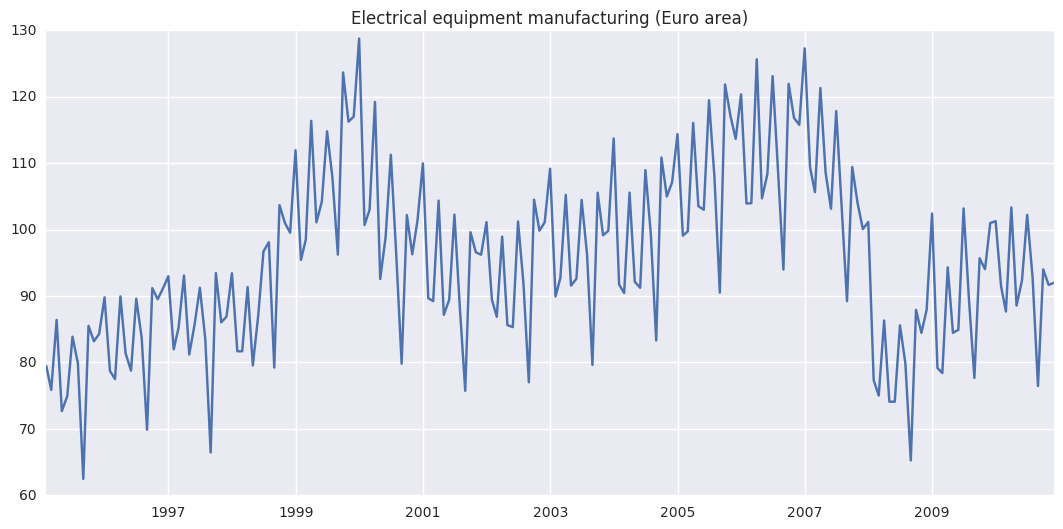

In [162]:
data = load_rda('elecequip')
rng = pd.date_range('1/1995', periods=data.shape[0], freq='M')
elecequip = pd.Series(data, index=rng)
plt.plot(elecequip)
_ = plt.title("Electrical equipment manufacturing (Euro area)")

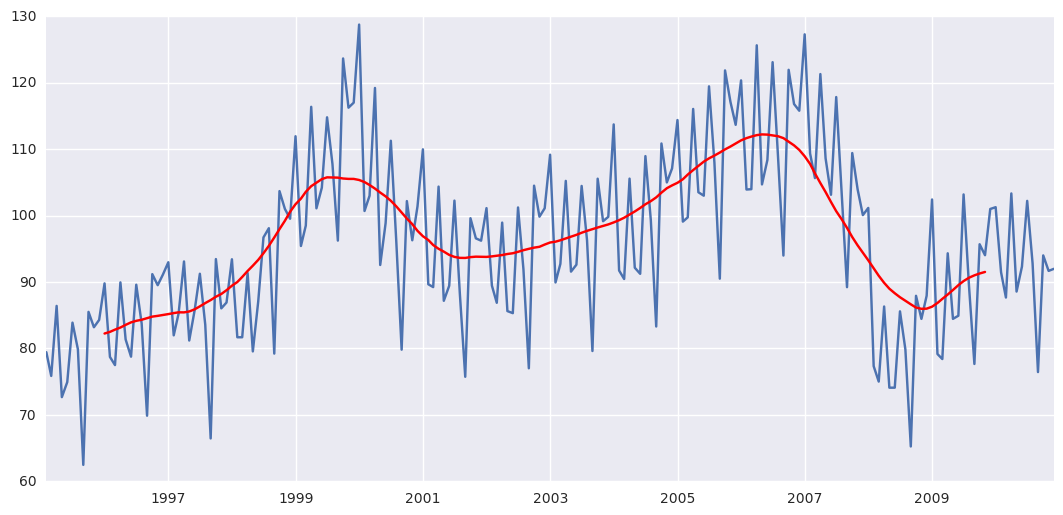

In [169]:
plt.plot(elecequip)
ee12 = elecequip.rolling(window=24, center=False).mean()
_ = plt.plot(ee12.rolling(window=2, center=False).mean().shift(-13), c='red')

### Weighted moving averages
Combinations of moving averages result in weighted moving averages. For example, the $2 \times 4 \text{-MA}$ discussed above is equivalent to a weighted $5\text{-MA}$ with weights given by $[\frac{1}{8},\frac{1}{4},\frac{1}{4},\frac{1}{4},\frac{1}{8}]$. In general, a weighted mm-MA can be written as

$$ \hat{T}_t = \sum_{i=-k}^{k} a_i y_t+i $$

where $k=(m−1)/2$ and the weights are given by $[a_{−k},\ldots,a_k]$. It is important that the weights all sum to one and that they are symmetric so that $a_i=a_{−i}$. The simple $m\text{-MA}$ is a special case where all the weights are equal to $1/m$. A major advantage of weighted moving averages is that they yield a smoother estimate of the trend-cycle. Instead of observations entering and leaving the calculation at full weight, their weights are slowly increased and then slowly decreased resulting in a smoother curve. Some specific sets of weights are widely used.

| Name    | $a_0$ | $a_1$ | $a_2$ | $a_3$ | $a_4$ | $a_5$ | $a_6$ | $a_7$ | $a_8$ | $a_9$ | $a_{10}$ | $a_{11}$ |
|---------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|--------|--------|
| 3-MA    | .333  | .333  |       |       |       |       |       |       |       |       |        |        |
| 5-MA    | .200  | .200  | .200  |       |       |       |       |       |       |       |        |        |
| 2X12-MA | .083  | .083  | .083  | .083  | .083  | .083  | .042  |       |       |       |        |        |
| 3X3 MA  | .333  | .222  | .111  |       |       |       |       |       |       |       |        |        |
| 3X5 MA  | .200  | .200  | .133  | .067  |       |       |       |       |       |       |        |        |
| S15-MA  | .231  | .209  | .144  | .066  | .009  | -.016 | -.019 | -.009 |       |       |        |        |
| S21-MA  | .171  | .163  | .134  | .037  | .051  | .017  | -.006 | -.014 | -.014 | -.009 | -.003  |        |
| H5-MA   | .558  | .294  | -.073 |       |       |       |       |       |       |       |        |        |
| H9-MA   | .330  | .267  | .119  | -.010 | -.041 |       |       |       |       |       |        |        |
| H13-MA  | .240  | .214  | .147  | .066  | .000  | -.028 | -.019 |       |       |       |        |        |
| H23-MA  | .148  | .138  | .122  | .097  | .068  | .039  | .013  | -.005 | -.015 | -.016 | -.011  | -.004  |

S = Spencer’s weighted moving average <BR>
H = Henderson’s weighted moving average

## Classical Decomposition

The classical decomposition method originated in the 1920s. It is a relatively simple procedure and forms the basis for most other methods of time series decomposition. There are two forms of classical decomposition: an additive decomposition and a multiplicative decomposition. These are described below for a time series with seasonal period $m$ (e.g., $m=4$ for quarterly data, $m=12$ for monthly data, $m=7$ for daily data with a weekly pattern).

In classical decomposition, we assume the seasonal component is constant from year to year. These $m$ values are sometimes called the “seasonal indices”

### Additive decomposition

1. If $m$ is an even number, compute the trend-cycle component using a $2 \times m\text{-MA}$ to obtain $\hat{T}_t$. If $m$ is an odd number, compute the trend-cycle component using an $m\text{-MA}$ to obtain $\hat{T}_t$.

2. Calculate the detrended series: $y_t − \hat{T}_t$.

3. To estimate the seasonal component for each month, simply average the detrended values for that month. For example, the seasonal index for March is the average of all the detrended March values in the data. These seasonal indexes are then adjusted to ensure that they add to **zero**. The seasonal component is obtained by stringing together all the seasonal indices for each year of data. This gives $\hat{S}_t$.

4. The remainder component is calculated by subtracting the estimated seasonal and trend-cycle components: $\hat{E}_t = y_t − \hat{T}_t − \hat{S}_t$.

### Multiplicative decomposition

A classical multiplicative decomposition is very similar except the subtractions are replaced by divisions.

1. The same as additive

2. Calculate the detrended series: $y_t / \hat{T}_t$.

3. To estimate the seasonal component for each month, simply average the detrended values for that month. For example, the seasonal index for March is the average of all the detrended March values in the data. These seasonal indexes are then adjusted to ensure that they add to $\boldsymbol{m}$. The seasonal component is obtained by stringing together all the seasonal indices for each year of data. This gives $\hat{S}_t$.

4. The remainder component is calculated by subtracting the estimated seasonal and trend-cycle components: $\hat{E}_t = y_t /(\hat{T}_t  \hat{S}_t)$.

### W praktyce
Wypróbujmy gotową metode `tsa.seasonal.seasonal_decompose` z paczki `statsmodels`

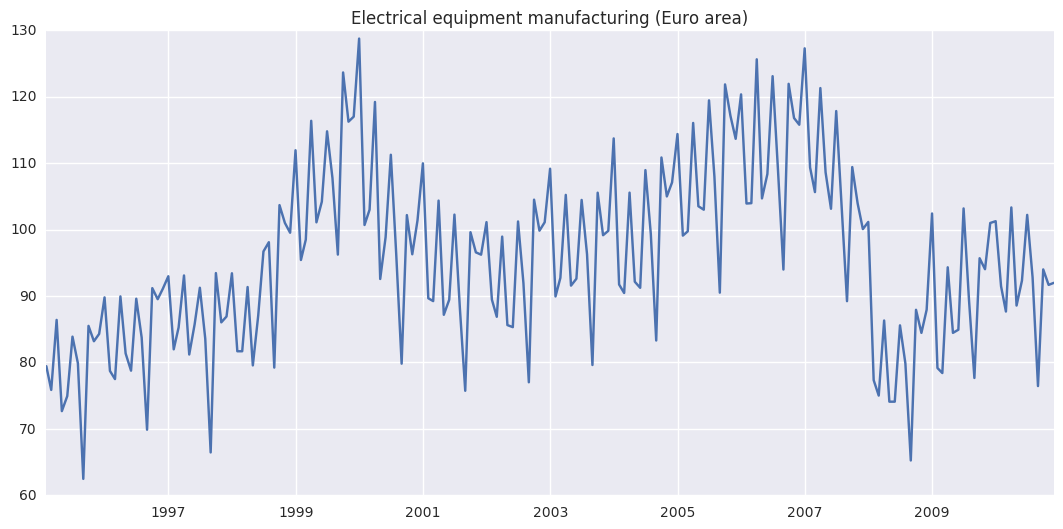

In [5]:
data = load_rda('elecequip')
rng = pd.date_range('1/1995', periods=data.shape[0], freq='M')
elecequip = pd.Series(data, index=rng)
plt.plot(elecequip)
_ = plt.title("Electrical equipment manufacturing (Euro area)")

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

dec = seasonal_decompose(elecequip, model='additive')
dir(dec)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'nobs',
 'observed',
 'plot',
 'resid',
 'seasonal',
 'trend']

In [78]:
sm_seasons = dec.seasonal
sm_trend = dec.trend
sm_resid = dec.resid

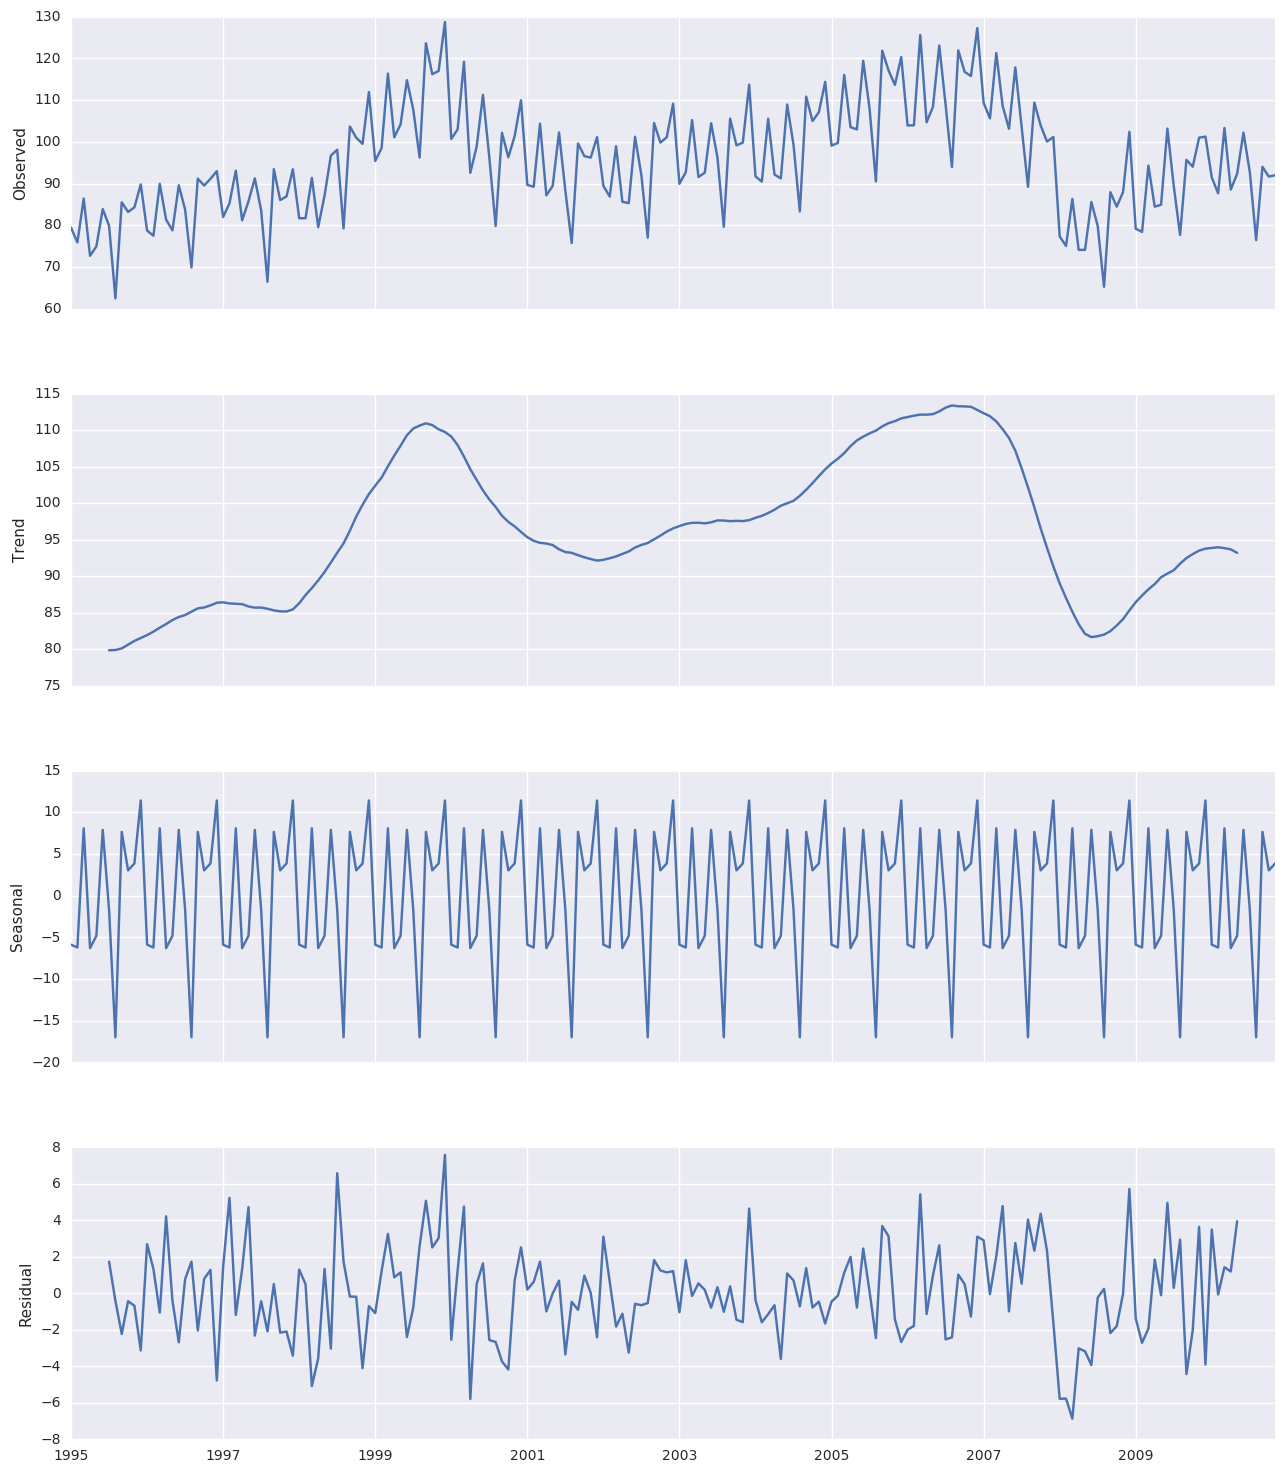

In [54]:
f = dec.plot()
f.set_figheight(16)

### Ale jaka to była dekompozycja dokładnie?

Zobaczmy co mówi dokumentacja

```
This is a naive decomposition. More sophisticated methods should be preferred.

The additive model is Y[t] = T[t] + S[t] + e[t]

The multiplicative model is Y[t] = T[t] * S[t] * e[t]

The seasonal component is first removed by applying a convolution filter to the data. The average of this 
smoothed series for each period is the returned seasonal component.
```

Niewiele...

Spróbujmy zrobić ręcznie to co było wyżej

### Step 1. 
Dane są "miesięczne", więc zróbmy $2 \times 12 \text{-MA}$

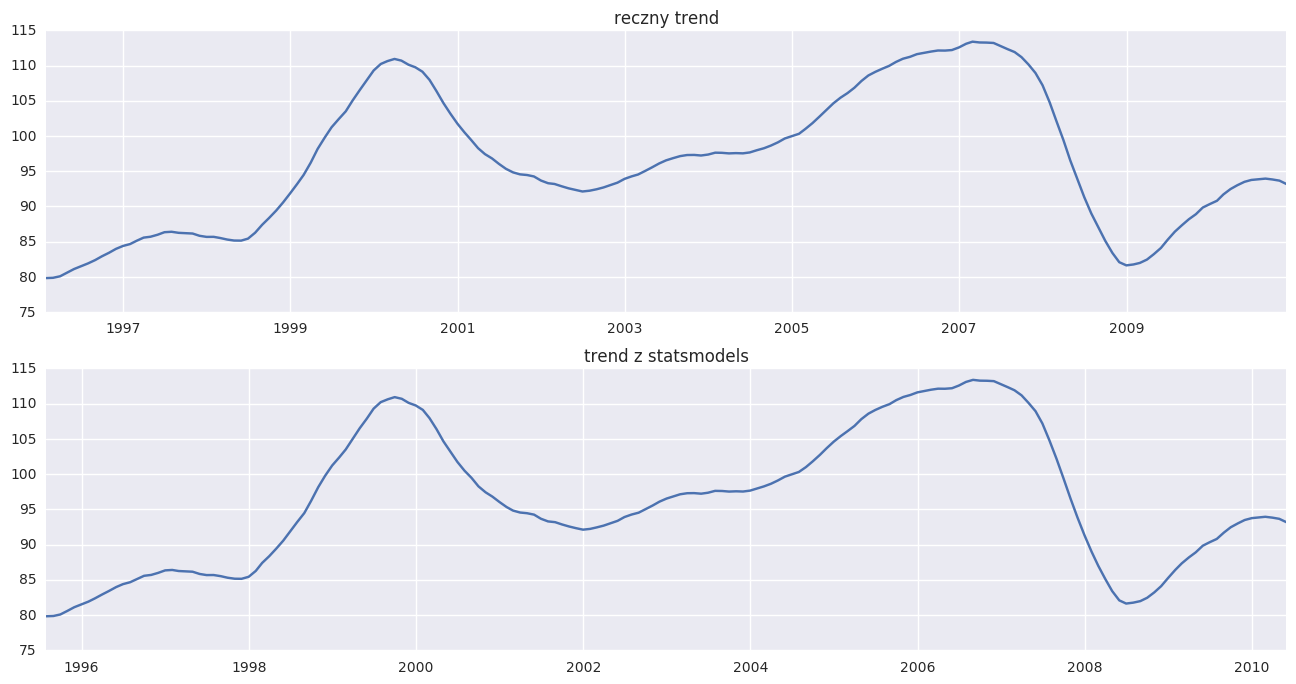

In [182]:
ee = elecequip.copy()
ee12 = ee.rolling(window=12, center=False).mean()
trend = ee12.rolling(window=2, center=True).mean()

f = plt.figure(figsize=(16,8))
ax1 = f.add_subplot(211)
ax1.plot(trend)
ax1.set_title("reczny trend")
ax2 = f.add_subplot(212)
ax2.plot(sm_trend)
ax2.set_title("trend z statsmodels")

### Step 2.
Detrend

In [186]:
d = detrend.rolling(window=12, center=False).mean()
d2 = d.rolling(window=2, center=True).mean()

In [179]:
d2

<bound method Rolling.mean of Rolling [window=2,center=True,axis=0]>

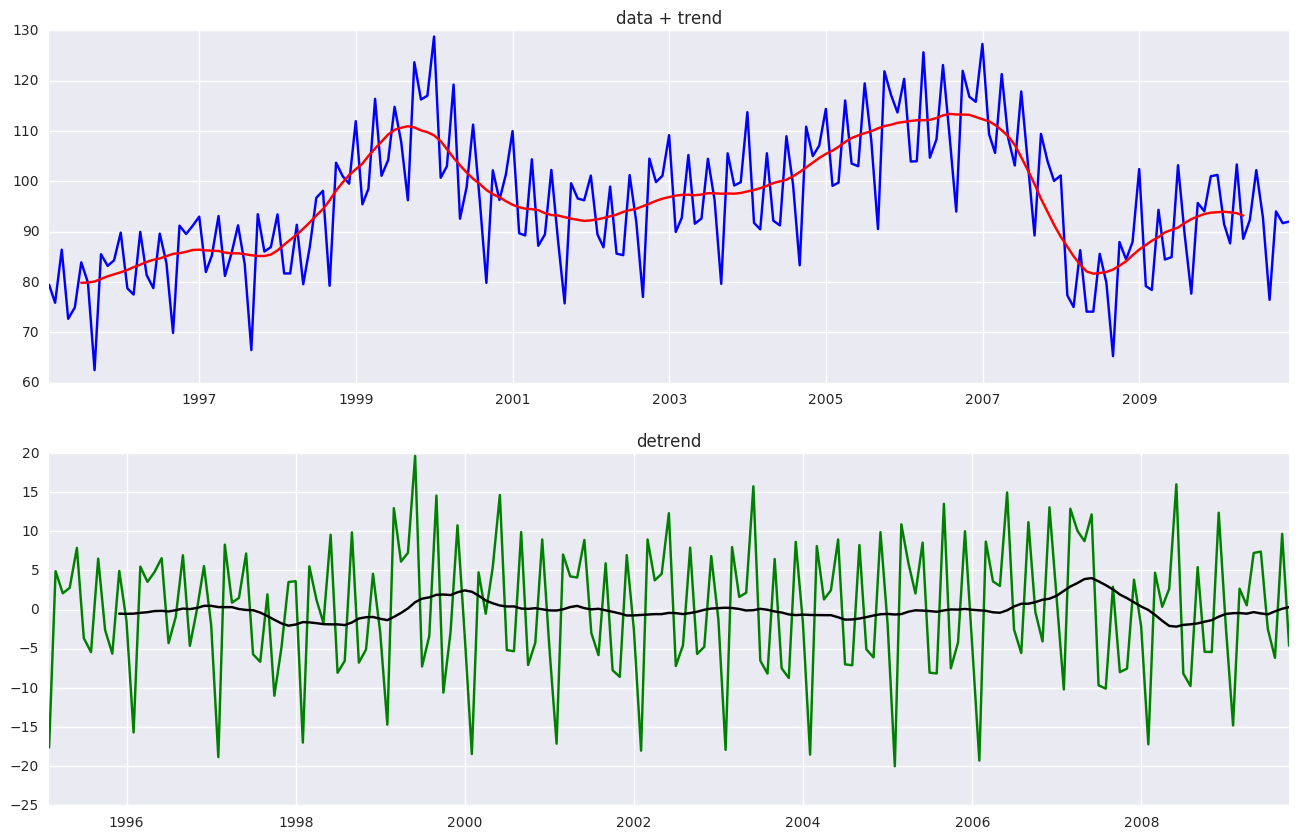

In [188]:
strend = trend.shift(-7)
detrend = ee - strend
f = plt.figure(figsize=(16,10))
ax1 = f.add_subplot(211)
ax1.plot(ee, c='b')
ax1.plot(strend, c='r')
ax1.set_title("data + trend")
ax2 = f.add_subplot(212)
ax2.plot(detrend.shift(-7), c='g')
ax2.plot(d2.shift(-7), c='k')
ax2.set_title("detrend")


### Step 3
Sezonowość - uśrednić dla każdego miesiąca tego "zdetrendowane" wartości po latach, przesunąć żeby sumowały się do 0

In [95]:
m = ee.index.month
seas = np.array([ee[m == i+1].mean() for i in xrange(12)])
seasons = pd.Series((16 *  (seas - seas.mean()).tolist())[:-1], index=ee.index)
unnormed_seasons = pd.Series((16 *  seas.tolist())[:-1], index=ee.index)

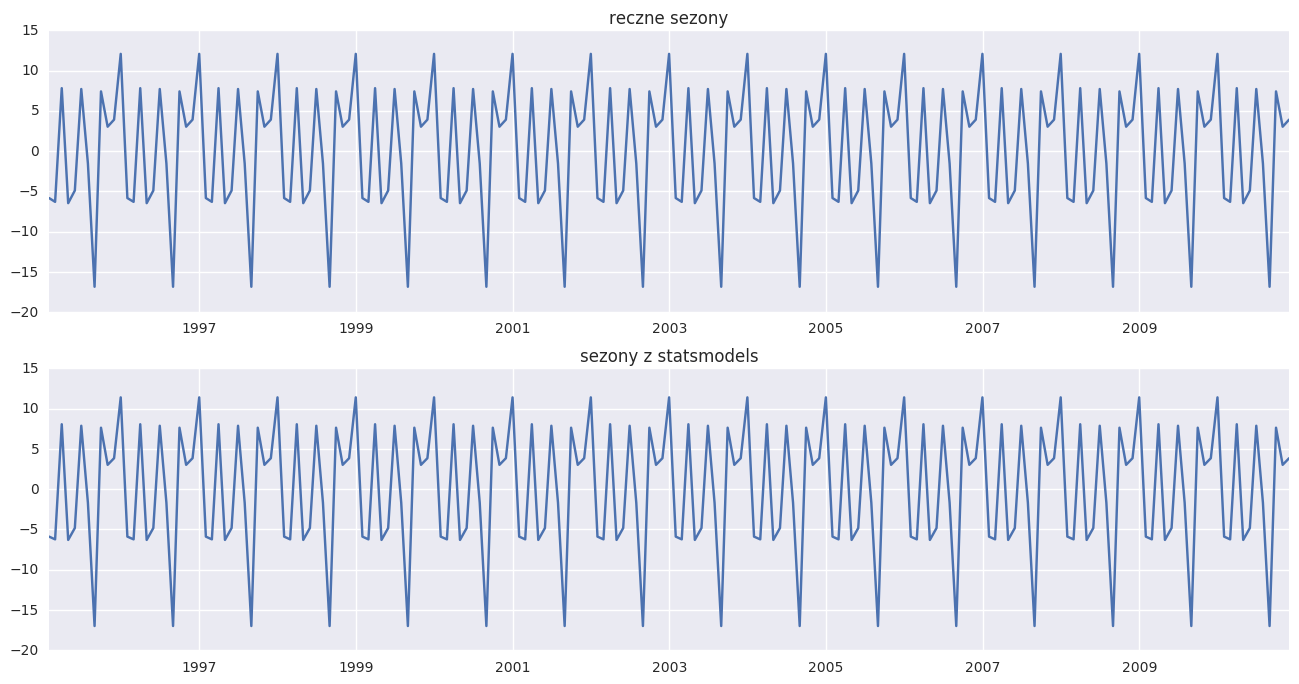

In [88]:
f = plt.figure(figsize=(16,8))
ax1 = f.add_subplot(211)
ax1.plot(seasons)
ax1.set_title("reczne sezony")
ax2 = f.add_subplot(212)
ax2.plot(sm_seasons)
ax2.set_title("sezony z statsmodels")

### Step 4.
Wyliczyć reszte - odjąc trend i sezony od oryginalnych danych

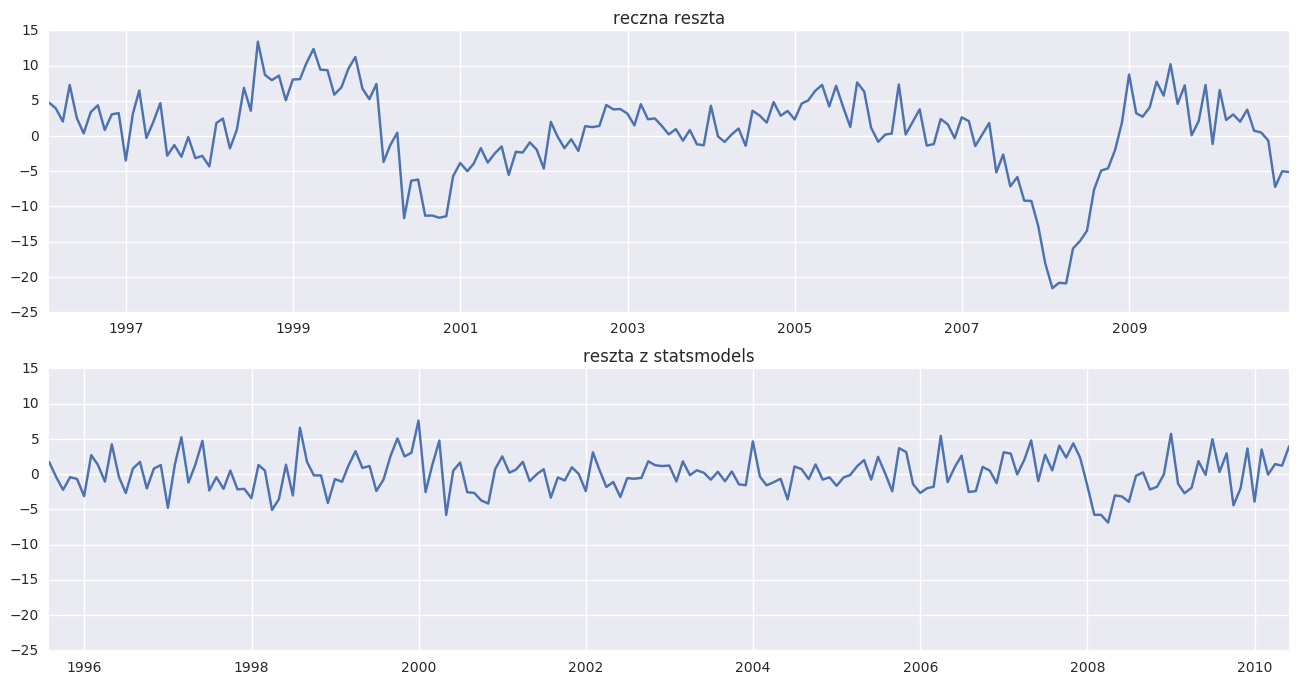

In [107]:
residual = ee - trend - seasons

f = plt.figure(figsize=(16,8))
ax1 = f.add_subplot(211)
ax1.plot(residual)
ax1.set_title("reczna reszta")
ax2 = f.add_subplot(212)
ax2.plot(sm_resid)
ax2.set_ylim(-25, 15)
ax2.set_title("reszta z statsmodels")

**Pytanie:** Skoro trend i sezony są takie same czemu reszta jest inna? Bug? Feature?

Spójrzmy na "zdetrendowany" szereg

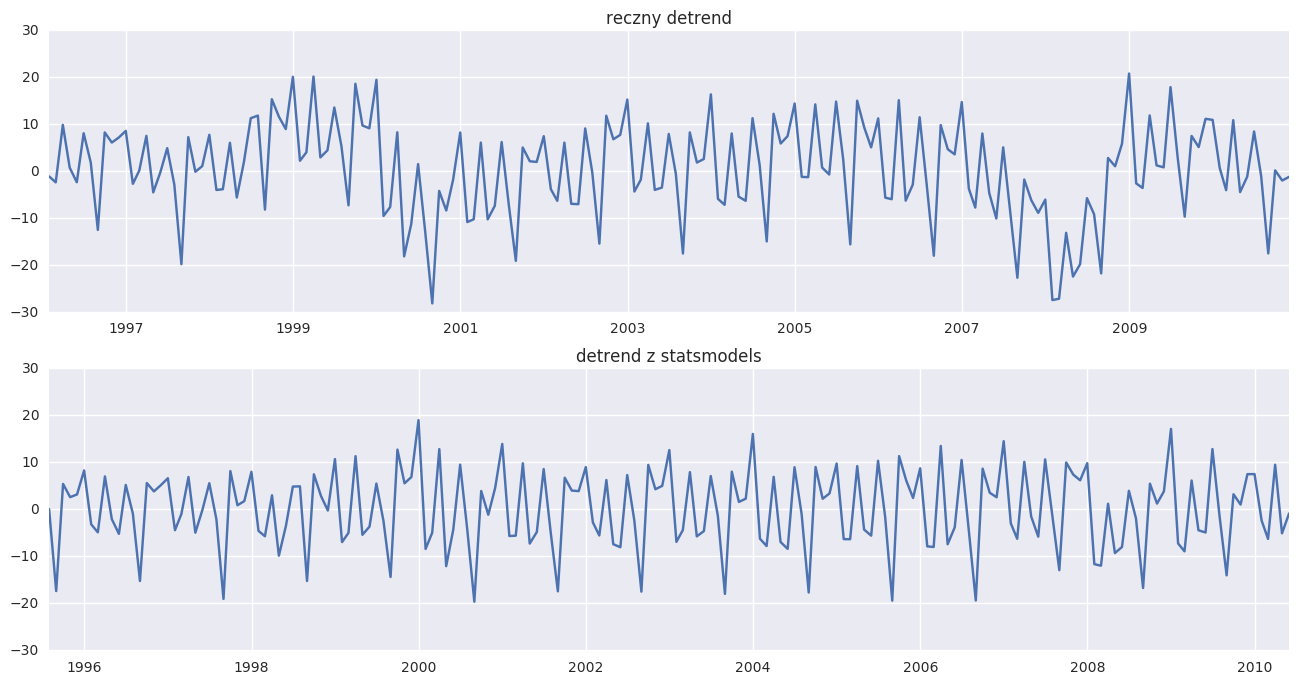

In [136]:
f = plt.figure(figsize=(16,8))
ax1 = f.add_subplot(211)
ax1.plot(ee - trend)
ax1.set_title("reczny detrend")
ax2 = f.add_subplot(212)
ax2.plot(ee - sm_trend)
ax2.set_ylim(-30, 30)
ax2.set_title("detrend z statsmodels")

Ewidentnie inne, ale przecież trendy były takie same...

![wut](travolta.gif "nosy little bastard aren't you")

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

**Czy napewno?**

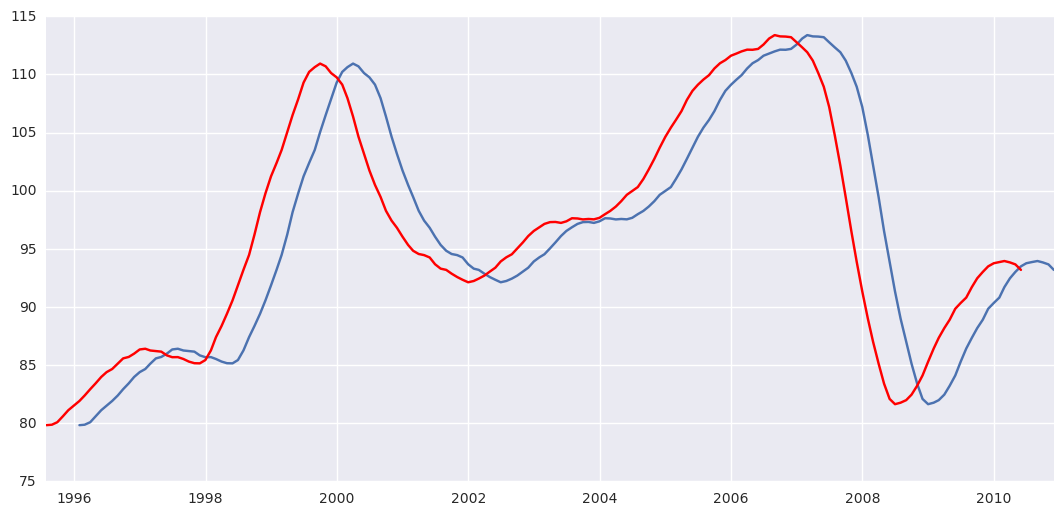

In [127]:
plt.plot(trend)
plt.plot(sm_trend, c='r')

In [157]:
df = pd.DataFrame({"moje": trend, "sm": sm_trend})
df.head(15)

,moje,sm
1995-01-31,NaN,NaN
1995-02-28,NaN,NaN
1995-03-31,NaN,NaN
1995-04-30,NaN,NaN
1995-05-31,NaN,NaN
1995-06-30,NaN,NaN
1995-07-31,NaN,79.827917
1995-08-31,NaN,79.866250
1995-09-30,NaN,80.081667
1995-10-31,NaN,80.590833


In [159]:
df.tail(15)

,moje,sm
2009-09-30,88.175833,92.462083
2009-10-31,88.898333,93.008750
2009-11-30,89.841667,93.488333
2009-12-31,90.337500,93.756250
2010-01-31,90.802083,93.856667
2010-02-28,91.700833,93.946667
2010-03-31,92.462083,93.825833
2010-04-30,93.008750,93.657500
2010-05-31,93.488333,93.183750
2010-06-30,93.756250,NaN


### Różnice jeszcze raz
Z przesunietym trendem

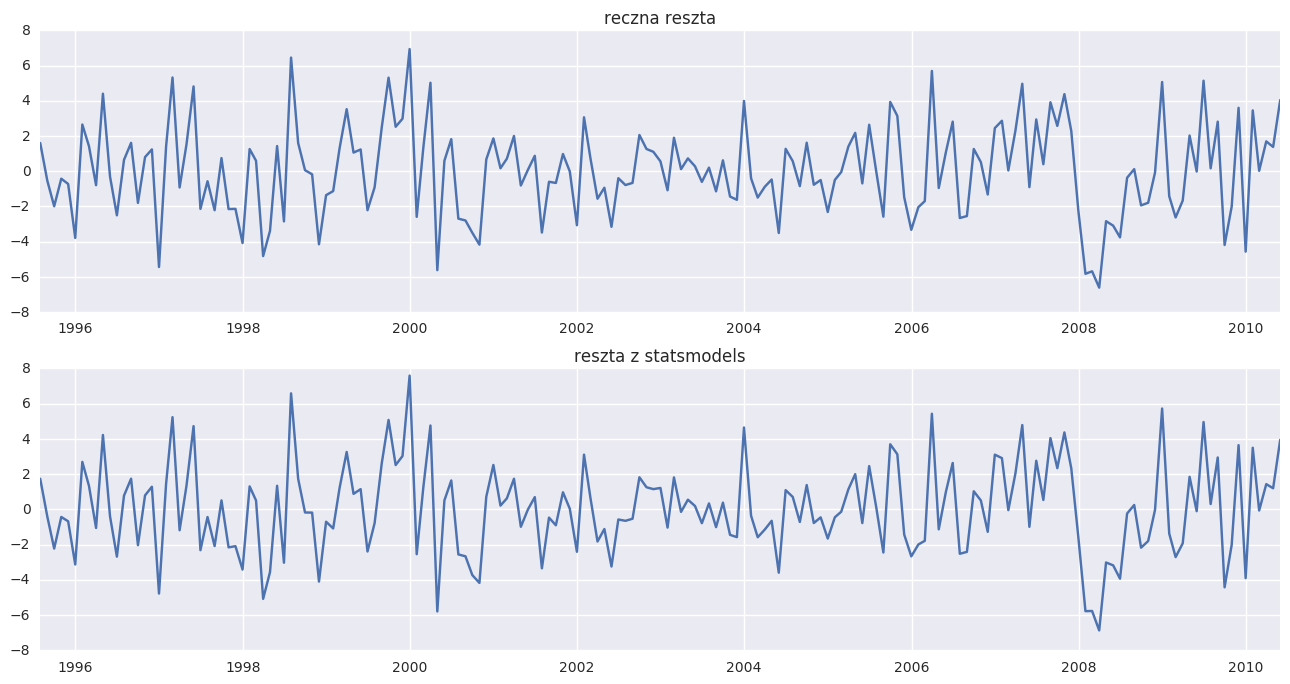

In [150]:
residual = ee - trend.shift(-6) - seasons

f = plt.figure(figsize=(16,8))
ax1 = f.add_subplot(211)
ax1.plot(residual)
ax1.set_title("reczna reszta")
ax2 = f.add_subplot(212)
ax2.plot(sm_resid)
ax2.set_title("reszta z statsmodels")

### Podsumowywując

Dokompozycja ze `statsmodels` jest klasyczną (naiwną) dekompozycją, z problemami

## Comments on classical decomposition

While classical decomposition is still widely used, it is not recommended. There are now several much better methods. Some of the problems with classical decomposition are summarized below.

* The estimate of the trend is unavailable for the first few and last few observations. For example, if $m=12$, there is no trend estimate for the first six and last six observations. Consequently, there is also no estimate of the remainder component for the same time periods.

* Classical decomposition methods assume that the seasonal component repeats from year to year. For many series, this is a reasonable assumption, but for some longer series it is not. For example, electricity demand patterns have changed over time as air conditioning has become more widespread. So in many locations, the seasonal usage pattern from several decades ago had maximum demand in winter (due to heating), while the current seasonal pattern has maximum demand in summer (due to air conditioning). The classical decomposition methods are unable to capture these seasonal changes over time.

* Occasionally, the value of the time series in a small number of periods may be particularly unusual. For example, monthly air passenger traffic may be affected by an industrial dispute making the traffic during the dispute very different from usual. The classical method is not robust to these kinds of unusual values.